In [1]:
%pip install -q datasets evaluate pyyaml gluonts torch transformers accelerate chronos chronos-forecasting statsforecast cdsapi

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 126.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 99.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 98.9 MB/s eta 0:00:00
   ━

## Dataset of sea level (*https://www.star.nesdis.noaa.gov/socd/lsa/SeaLevelRise/LSA_SLR_timeseries.php*)

In [2]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import torch
import sys
from datetime import datetime, timedelta
from distutils.util import strtobool
from statsforecast import StatsForecast
from statsforecast.models import SeasonalNaive, Naive, AutoARIMA
from gluonts.ev.metrics import MASE, MeanWeightedSumQuantileLoss
from gluonts.model.evaluation import evaluate_forecasts
from gluonts.dataset.split import split
from gluonts.model.forecast import SampleForecast, QuantileForecast
from gluonts.evaluation import Evaluator
from gluonts.dataset.common import ListDataset
from tqdm.auto import tqdm

In [18]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


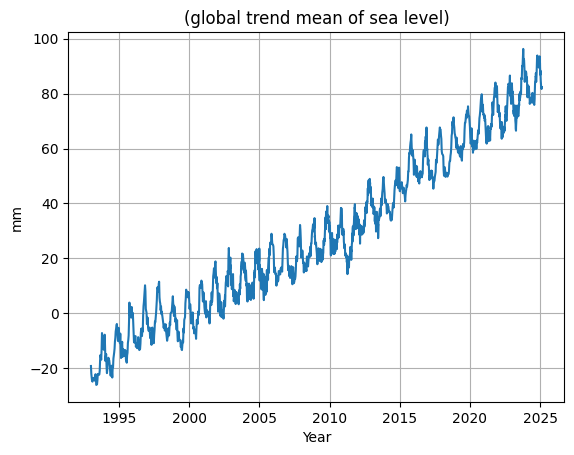

In [4]:
# Load the CSV, skipping the first 6 rows (metadata/header info)
df = pd.read_csv("/content/drive/MyDrive/dataset/Dataset_sea_level_extension/DATASET_NATURE_ARTICLE/global_mean_sea_level/slr_sla_gbl_keep_all_66.csv", skiprows=6)

# Rename the first column to 'time' for clarity
df.rename(columns={df.columns[0]: "time"}, inplace=True)

# Compute the mean value per row (ignoring NaNs), excluding the first column
df["sea_level_altitude"] = df.iloc[:, 1:].mean(axis=1, skipna=True)

# Create the final DataFrame with only the required columns
final_global_mean_df = df[["time", "sea_level_altitude"]]

# Plotting
plt.ylabel("mm")
plt.xlabel("Year")
plt.grid()
plt.plot(final_global_mean_df["time"], final_global_mean_df["sea_level_altitude"])
plt.title("(global trend mean of sea level)")
plt.show()

In [5]:
sea_list = [sea for sea in os.listdir("/content/drive/MyDrive/dataset/Dataset_sea_level_extension/DATASET_NATURE_ARTICLE/SEA_TAKEN_SINGULARLY")]
sea_list

['ATLANTIC_OCEAN',
 'BALTIC_SEA',
 'GULF_of_AMERICA',
 'ANDAMAN_SEA',
 'BERING_SEA',
 'BAY_OF_BENGALS',
 'INDIAN_OCEAN',
 'ADRIATIC_SEA',
 'ARABIAN_SEA',
 'CARIBBEAN_SEA',
 'SEA_of_OKHOTSK',
 'PERSIAN_GULF',
 'NORTH_SEA',
 'SEA_of_JAPAN',
 'INDONESIAN',
 'PACIFIC_OCEAN',
 'MEDITERRANEAN_SEA',
 'NORTH_PACIFIC_OCEAN',
 'NORTH_ATLANTIC_OCEAN',
 'TROPICS',
 'SOUTH_CHINA_SEA',
 'YELLOW_SEA']

In [6]:
# sea: one of the folders printed above
# keep_seasonality: whether to keep seasonal signals -> True or remove them -> False
# inside_66: if True, only takes sea level measurements between -66° & 66°
def clean_data_by_the_sea(sea: str, keep_seasonality=True, inside_66=True):
    sea_folder_path = "/content/drive/MyDrive/dataset/Dataset_sea_level_extension/DATASET_NATURE_ARTICLE/SEA_TAKEN_SINGULARLY/" + sea + "/"
    csv_list = [csv for csv in os.listdir(sea_folder_path)]
    csv = ""

    if inside_66:
        csv_list = [csv for csv in csv_list if csv.endswith("66.csv")]
        if keep_seasonality:
            csv_list = [csv for csv in csv_list if "keep" in csv]
            csv = sea_folder_path + csv_list[0]
        else:
            csv_list = [csv for csv in csv_list if "free" in csv]
            csv = sea_folder_path + csv_list[0]
    else:
        csv_list = [csv for csv in csv_list if csv.endswith("90.csv")]
        if keep_seasonality:
            csv_list = [csv for csv in csv_list if "keep" in csv]
            csv = sea_folder_path + csv_list[0]
        else:
            csv_list = [csv for csv in csv_list if "free" in csv]
            csv = sea_folder_path + csv_list[0]

    # Load the CSV, skipping the first 6 rows (metadata)
    df = pd.read_csv(csv, skiprows=6)

    # Rename the first column to 'time' for clarity
    df.rename(columns={df.columns[0]: "time"}, inplace=True)

    # Compute the row-wise mean (ignoring NaNs), excluding the first column
    df["sea_level_altitude"] = df.iloc[:, 1:].mean(axis=1, skipna=True)

    # Create the final DataFrame with only the required columns
    final_sea_level_df = df[["time", "sea_level_altitude"]]

    return final_sea_level_df

##### To see the different sea data, insert the name in the list  ['ATLANTIC_OCEAN', 'BALTIC_SEA', 'GULF_of_AMERICA', 'ANDAMAN_SEA', 'BERING_SEA', 'BAY_OF_BENGALS','INDIAN_OCEAN','ADRIATIC_SEA', 'ARABIAN_SEA', 'CARIBBEAN_SEA', 'SEA_of_OKHOTSK', 'PERSIAN_GULF', 'NORTH_SEA', 'SEA_of_JAPAN''INDONESIAN', 'PACIFIC_OCEAN', 'MEDITERRANEAN_SEA', 'NORTH_PACIFIC_OCEAN', 'NORTH_ATLANTIC_OCEAN', 'TROPICS', 'SOUTH_CHINA_SEA', 'YELLOW_SEA']

In [7]:
sea_df = clean_data_by_the_sea("BALTIC_SEA")

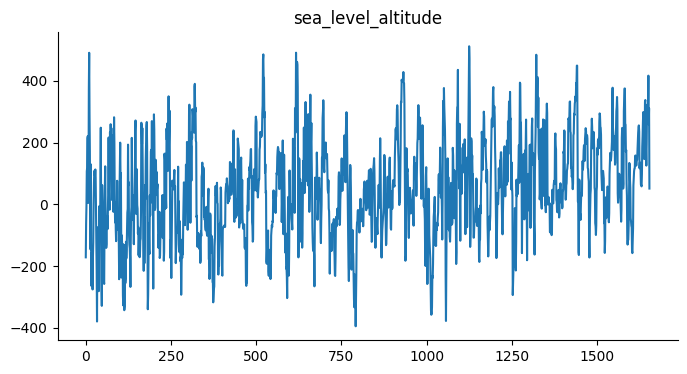

In [8]:
# sea_level_altitude
from matplotlib import pyplot as plt
sea_df['sea_level_altitude'].plot(kind='line', figsize=(8, 4), title='sea_level_altitude')
plt.gca().spines[['top', 'right']].set_visible(False)

## Upload chronos method to see the forecasting

In [9]:
# This is for prediction forecast
from chronos.base import BaseChronosPipeline, ForecastType
pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-t5-tiny",  # use "amazon/chronos-bolt-small" for the corresponding Chronos-Bolt model
    device_map="cpu",  # use "cpu" for CPU inference
    torch_dtype=torch.bfloat16,
)

def plot_forecast(df, n_forecast=25, pipeline=pipeline, flag_quantiles=False):
    """
    Plot forecast for a given time series using Chronos pipeline.

    Args:
        df (pd.Series or pd.DataFrame column): Time series data
        n_forecast (int): Number of future time steps to predict
        flag_quantiles (bool): If True, use quantile-based forecast instead of sampling
    """
    df = df.reset_index(drop=True)

    if len(df) <= n_forecast + 1:
        raise ValueError("Data is too short for the requested forecast horizon.")

    # Remove last n_forecast points from the series to simulate forecasting
    df_base = df[:-n_forecast].astype(float).to_numpy()
    context = torch.tensor(df_base)

    if flag_quantiles:
        # Predict quantiles directly (0.1, 0.5, 0.9)
        quantiles, _ = pipeline.predict_quantiles(
            context=context,
            prediction_length=n_forecast,
            quantile_levels=[0.1, 0.5, 0.9],
            limit_prediction_length=True,
        )
        low, median, high = quantiles[0, :, 0], quantiles[0, :, 1], quantiles[0, :, 2]
    else:
        # Sample forecast and compute quantiles from samples
        forecast = pipeline.predict(
            context,
            prediction_length=n_forecast,
            num_samples=25,
            temperature=1.0,
            top_k=50,
            top_p=1.0,
        )
        low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

    # Build forecast index
    forecast_index = range(len(df) - n_forecast, len(df))

    # Append last real value to connect forecast with past
    last_real_value = df.iloc[-n_forecast - 1]
    last_real_index = len(df) - n_forecast - 1

    # Extend median and confidence intervals
    median_full = np.insert(median, 0, last_real_value)
    low_full = np.insert(low, 0, last_real_value)
    high_full = np.insert(high, 0, last_real_value)
    forecast_index_full = np.insert(forecast_index, 0, last_real_index)

    # Plotting
    plt.figure(figsize=(16, 8))
    plt.plot(df, color="royalblue", label="historical data")
    plt.plot(forecast_index_full[:2], median_full[:2], color="tomato", linestyle="dashed")
    plt.plot(forecast_index_full[1:], median_full[1:], color="tomato", label="median forecast")
    plt.fill_between(forecast_index_full, low_full, high_full, color="tomato", alpha=0.3, label="80% prediction interval")

    plt.title("Sea Level Forecast")
    plt.xlabel("Time Step")
    plt.ylabel("Sea Level")
    plt.legend()
    plt.grid()
    plt.show()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/33.6M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

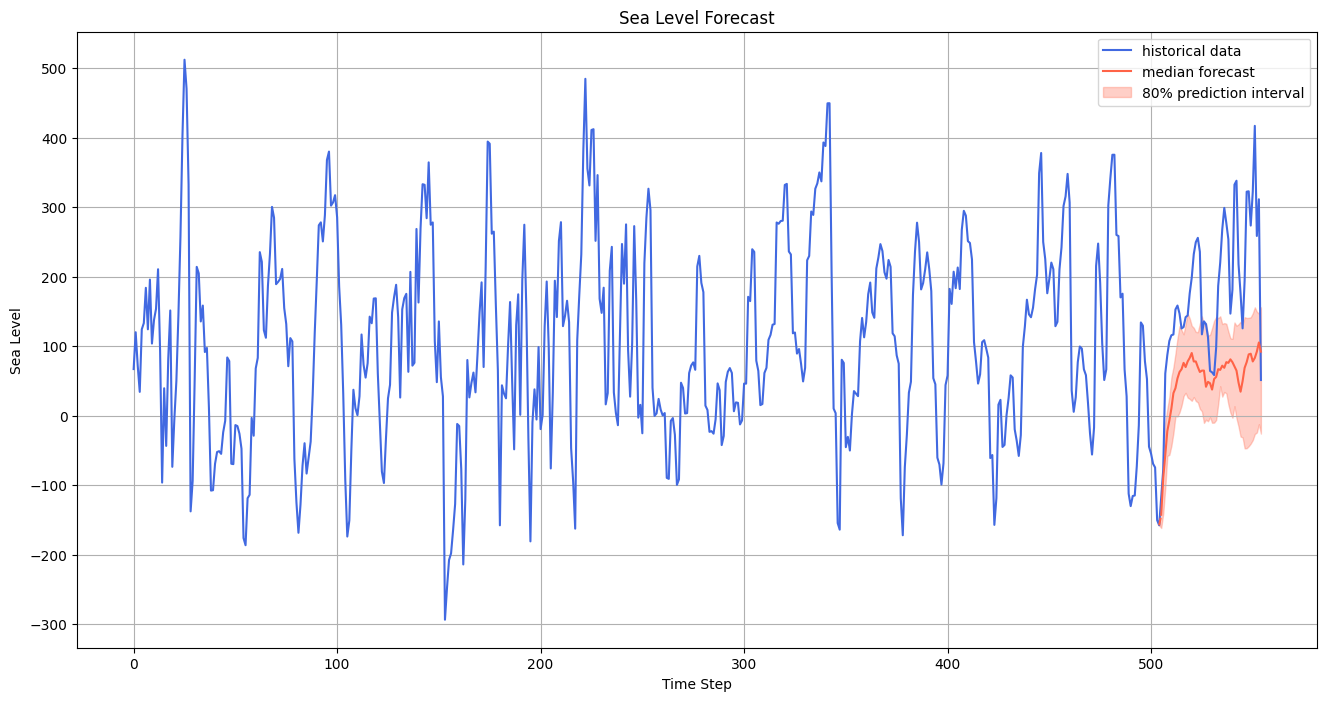

In [10]:
plot_forecast(sea_df['sea_level_altitude'][1100:], pipeline=pipeline, n_forecast=50)

In [11]:
"""import os
import pandas as pd

# Directory dove salvare i CSV
output_dir = "/content/drive/MyDrive/outputto"
os.makedirs(output_dir, exist_ok=True)

# Numero di punti da escludere alla fine
cutoff = 48

# Ciclo su ciascun mare
for sea in sea_list:
    try:
        print(f"🌊 Cleaning data for {sea}")
        df = clean_data_by_the_sea(sea, keep_seasonality=True, inside_66=False)

        # Rimuovi gli ultimi 48 valori
        cleaned_df = df[:-cutoff]

        # Salva il DataFrame in CSV
        filename = f"{sea}_cleaned_outside_66.csv"
        output_path = os.path.join(output_dir, filename)
        cleaned_df.to_csv(output_path, index=False)
        print(f"✅ Saved: {output_path}")

    except Exception as e:
        print(f"❌ Error processing {sea}: {e}")
"""

'import os\nimport pandas as pd\n\n# Directory dove salvare i CSV\noutput_dir = "/content/drive/MyDrive/outputto"\nos.makedirs(output_dir, exist_ok=True)\n\n# Numero di punti da escludere alla fine\ncutoff = 48\n\n# Ciclo su ciascun mare\nfor sea in sea_list:\n    try:\n        print(f"🌊 Cleaning data for {sea}")\n        df = clean_data_by_the_sea(sea, keep_seasonality=True, inside_66=False)\n\n        # Rimuovi gli ultimi 48 valori\n        cleaned_df = df[:-cutoff]\n\n        # Salva il DataFrame in CSV\n        filename = f"{sea}_cleaned_outside_66.csv"\n        output_path = os.path.join(output_dir, filename)\n        cleaned_df.to_csv(output_path, index=False)\n        print(f"✅ Saved: {output_path}")\n        \n    except Exception as e:\n        print(f"❌ Error processing {sea}: {e}")\n'

## In domain evaluation

In [12]:
# Upload the right Chronos model
pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-t5-tiny",  # use "amazon/chronos-bolt-small" for the corresponding Chronos-Bolt model
    device_map="cpu",  # use "cpu" for CPU inference
    torch_dtype=torch.bfloat16,
)

In [13]:
# 🔧 Convert a DataFrame to GluonTS-compatible format
def to_gluonts_entry(df: pd.DataFrame, freq="M"):
    df["time"] = pd.to_datetime(df["time"])
    return {
        "start": pd.Period(df["time"].iloc[0], freq=freq),
        "target": df["sea_level_altitude"].to_numpy()
    }

# ⚙️ Perform forecasting and evaluation using a Chronos pipeline and GluonTS metrics
def evaluate_sea_level_series(series_dict, pipeline, prediction_length=48):
    # Create test instances using GluonTS split utilities
    _, test_template = split([series_dict], offset=-prediction_length)
    test_data = test_template.generate_instances(prediction_length=prediction_length, windows=1)

    # Forecast loop using the Chronos pipeline
    forecast_outputs = []
    for ts in test_data.input:
        context = torch.tensor(ts["target"])
        forecast = pipeline.predict([context], prediction_length=prediction_length).numpy()
        forecast_outputs.append(forecast[0])

    # Format forecast into GluonTS-compatible objects
    forecasts = []
    for item, ts in zip(forecast_outputs, test_data.input):
        start = ts["start"] + len(ts["target"])
        if pipeline.forecast_type == ForecastType.SAMPLES:
            forecasts.append(SampleForecast(samples=item, start_date=start))
        elif pipeline.forecast_type == ForecastType.QUANTILES:
            forecasts.append(QuantileForecast(
                forecast_arrays=item,
                forecast_keys=list(map(str, pipeline.quantiles)),
                start_date=start
            ))

    # Evaluate using GluonTS metrics
    metrics = evaluate_forecasts(
        forecasts=forecasts,
        test_data=test_data,
        metrics=[
            MASE(),
            MeanWeightedSumQuantileLoss(np.arange(0.1, 1.0, 0.1))
        ]
    )
    return metrics


# List of sea regions to evaluate
sea_names = sea_list  # Replace or define sea_list earlier in your script

rows = []
results = []

for sea in sea_names:
    print(f"\n🌊 Evaluating {sea}")
    df = clean_data_by_the_sea(sea, keep_seasonality=True, inside_66=True)
    entry = to_gluonts_entry(df)

    # Run forecast and evaluation
    metrics = evaluate_sea_level_series(entry, pipeline, prediction_length=48)

    # Store full metric dictionary and extract key values
    results.append({"sea": sea, **metrics})
    mase = metrics["MASE[0.5]"].item()
    wql = metrics["mean_weighted_sum_quantile_loss"].item()
    rows.append((sea, mase, wql))

# 📊 Create final results DataFrame
final_chronos_df = pd.DataFrame(rows, columns=["sea", "MASE", "WQL"])
display(final_chronos_df)

# 💾 Save results to CSV file
final_chronos_df.to_csv("sea_level_chronos_evaluation.csv", index=False)


🌊 Evaluating ATLANTIC_OCEAN


0it [00:00, ?it/s]/usr/local/lib/python3.11/dist-packages/gluonts/time_feature/seasonality.py:47: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
1it [00:00, 146.40it/s]



🌊 Evaluating BALTIC_SEA


0it [00:00, ?it/s]/usr/local/lib/python3.11/dist-packages/gluonts/time_feature/seasonality.py:47: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
1it [00:00, 161.19it/s]



🌊 Evaluating GULF_of_AMERICA


0it [00:00, ?it/s]/usr/local/lib/python3.11/dist-packages/gluonts/time_feature/seasonality.py:47: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
1it [00:00, 178.63it/s]



🌊 Evaluating ANDAMAN_SEA


0it [00:00, ?it/s]/usr/local/lib/python3.11/dist-packages/gluonts/time_feature/seasonality.py:47: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
1it [00:00, 102.63it/s]



🌊 Evaluating BERING_SEA


0it [00:00, ?it/s]/usr/local/lib/python3.11/dist-packages/gluonts/time_feature/seasonality.py:47: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
1it [00:00, 168.21it/s]



🌊 Evaluating BAY_OF_BENGALS


0it [00:00, ?it/s]/usr/local/lib/python3.11/dist-packages/gluonts/time_feature/seasonality.py:47: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
1it [00:00, 184.97it/s]



🌊 Evaluating INDIAN_OCEAN


0it [00:00, ?it/s]/usr/local/lib/python3.11/dist-packages/gluonts/time_feature/seasonality.py:47: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
1it [00:00, 198.95it/s]



🌊 Evaluating ADRIATIC_SEA


0it [00:00, ?it/s]/usr/local/lib/python3.11/dist-packages/gluonts/time_feature/seasonality.py:47: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
1it [00:00, 179.60it/s]



🌊 Evaluating ARABIAN_SEA


0it [00:00, ?it/s]/usr/local/lib/python3.11/dist-packages/gluonts/time_feature/seasonality.py:47: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
1it [00:00, 161.54it/s]



🌊 Evaluating CARIBBEAN_SEA


0it [00:00, ?it/s]/usr/local/lib/python3.11/dist-packages/gluonts/time_feature/seasonality.py:47: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
1it [00:00, 175.15it/s]



🌊 Evaluating SEA_of_OKHOTSK


0it [00:00, ?it/s]/usr/local/lib/python3.11/dist-packages/gluonts/time_feature/seasonality.py:47: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
1it [00:00, 163.32it/s]



🌊 Evaluating PERSIAN_GULF


0it [00:00, ?it/s]/usr/local/lib/python3.11/dist-packages/gluonts/time_feature/seasonality.py:47: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
1it [00:00, 185.06it/s]



🌊 Evaluating NORTH_SEA


0it [00:00, ?it/s]/usr/local/lib/python3.11/dist-packages/gluonts/time_feature/seasonality.py:47: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
1it [00:00, 175.51it/s]



🌊 Evaluating SEA_of_JAPAN


0it [00:00, ?it/s]/usr/local/lib/python3.11/dist-packages/gluonts/time_feature/seasonality.py:47: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
1it [00:00, 170.39it/s]



🌊 Evaluating INDONESIAN


0it [00:00, ?it/s]/usr/local/lib/python3.11/dist-packages/gluonts/time_feature/seasonality.py:47: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
1it [00:00, 178.57it/s]



🌊 Evaluating PACIFIC_OCEAN


0it [00:00, ?it/s]/usr/local/lib/python3.11/dist-packages/gluonts/time_feature/seasonality.py:47: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
1it [00:00, 169.34it/s]



🌊 Evaluating MEDITERRANEAN_SEA


0it [00:00, ?it/s]/usr/local/lib/python3.11/dist-packages/gluonts/time_feature/seasonality.py:47: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
1it [00:00, 174.61it/s]



🌊 Evaluating NORTH_PACIFIC_OCEAN


0it [00:00, ?it/s]/usr/local/lib/python3.11/dist-packages/gluonts/time_feature/seasonality.py:47: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
1it [00:00, 169.59it/s]



🌊 Evaluating NORTH_ATLANTIC_OCEAN


0it [00:00, ?it/s]/usr/local/lib/python3.11/dist-packages/gluonts/time_feature/seasonality.py:47: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
1it [00:00, 166.30it/s]



🌊 Evaluating TROPICS


0it [00:00, ?it/s]/usr/local/lib/python3.11/dist-packages/gluonts/time_feature/seasonality.py:47: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
1it [00:00, 163.12it/s]



🌊 Evaluating SOUTH_CHINA_SEA


0it [00:00, ?it/s]/usr/local/lib/python3.11/dist-packages/gluonts/time_feature/seasonality.py:47: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
1it [00:00, 170.03it/s]



🌊 Evaluating YELLOW_SEA


0it [00:00, ?it/s]/usr/local/lib/python3.11/dist-packages/gluonts/time_feature/seasonality.py:47: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
1it [00:00, 164.40it/s]


,sea,MASE,WQL
0,ATLANTIC_OCEAN,1.122207,0.176610
1,BALTIC_SEA,0.786174,0.607968
2,GULF_of_AMERICA,0.675179,0.215122
3,ANDAMAN_SEA,0.655600,0.291169
4,BERING_SEA,0.862648,0.370412
5,BAY_OF_BENGALS,0.811555,0.217334
6,INDIAN_OCEAN,0.806926,0.092122
7,ADRIATIC_SEA,0.818353,0.472821
8,ARABIAN_SEA,0.515257,0.197348
9,CARIBBEAN_SEA,0.649890,0.188718


## AutoARIMA implementation

In [14]:
def fractional_year_to_date(fractional_year):
    year = int(fractional_year)
    remainder = fractional_year - year
    start_of_year = datetime(year, 1, 1)
    # Calculate how many seconds represent the fractional part of the year
    days_in_year = 366 if is_leap_year(year) else 365
    date = start_of_year + timedelta(days=remainder * days_in_year)
    return date.strftime("%Y-%m-%d")

def is_leap_year(year):
    return year % 4 == 0

In [15]:
# Example
dates = [2024.3754, 2024.3972, 2024.4026, 2024.4243, 2024.4297]
converted_dates = [fractional_year_to_date(d) for d in dates]

for original, converted in zip(dates, converted_dates):
    print(f"{original} ➜ {converted}")

2024.3754 ➜ 2024-05-17
2024.3972 ➜ 2024-05-25
2024.4026 ➜ 2024-05-27
2024.4243 ➜ 2024-06-04
2024.4297 ➜ 2024-06-06


In [16]:
def evaluate_with_autoarima(df: pd.DataFrame, horizon: int = 48, freq: str = "D", continuous_year=True) -> dict:
    # Preprocessing per StatsForecast
    df_clean = df.copy()
    if continuous_year:
        df_clean["ds"] = df_clean["time"].apply(fractional_year_to_date)
    else:
        df_clean["ds"] = df_clean["time"]
    df_clean["y"] = df_clean["sea_level_altitude"]
    df_clean["unique_id"] = "sea"

    train_df = df_clean[:-horizon]
    test_df = df_clean[-horizon:]

    # Fit AutoARIMA
    sf = StatsForecast(models=[AutoARIMA()], freq=freq, n_jobs=1)
    sf.fit(train_df[["unique_id", "ds", "y"]])

    # Predict con confidence intervals
    forecast_df = sf.predict(h=horizon, level=[10, 20, 30, 40, 50, 60, 70, 80, 90])

    # 🔧 create TEST_DATA using split and generate_instances as Chronos
    full_target = df_clean["y"].to_numpy()
    series_dict = {
        "start": pd.Period(train_df["ds"].iloc[0], freq=freq),
        "target": full_target,
        "item_id": "sea"
    }

    # Use split to create the test template
    _, test_template = split([series_dict], offset=-horizon)
    test_data = test_template.generate_instances(prediction_length=horizon, windows=1)

    # 🔧 create FORECASTS in the GluonTS format
    y_pred = forecast_df["AutoARIMA"].to_numpy()
    forecast_start = pd.Period(test_df["ds"].iloc[0], freq=freq)

    # Map the quantiles in the correct format
    quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    forecast_arrays = []

    for q in quantiles:
        if q < 0.5:
            # For quantiles below 50%, look for “lo-XX” columns
            level = int((1-q)*100)
            col_name = f"AutoARIMA-lo-{level}"
        elif q == 0.5:
            # Median
            col_name = "AutoARIMA"
        else:
            # For quantiles above 50%, look for “hi-XX” columns
            level = int(q*100)
            col_name = f"AutoARIMA-hi-{level}"

        if col_name in forecast_df.columns:
            forecast_arrays.append(forecast_df[col_name].to_numpy())
        else:
            # If not found, use central prediction
            forecast_arrays.append(y_pred)

    # Create QuantileForecast
    forecasts = [QuantileForecast(
        forecast_arrays=np.array(forecast_arrays),
        forecast_keys=[str(q) for q in quantiles],
        start_date=forecast_start,
        item_id="sea"
    )]

    # 🔧 EVALUATION using test_data directly

    metrics = evaluate_forecasts(
        forecasts=forecasts,
        test_data=test_data,
        metrics=[
            MASE(),
            MeanWeightedSumQuantileLoss(np.arange(0.1, 1.0, 0.1))
        ]
    )

    return metrics

# List of sea regions to evaluate
sea_names = sea_list  # Replace or define sea_list earlier in your script

rows = []
results = []
for sea in sea_names:
    print(f"\n🌊 Evaluating AutoARIMA {sea}")
    try:
        df = clean_data_by_the_sea(sea, keep_seasonality=True, inside_66=True)
        metrics = evaluate_with_autoarima(df, horizon=48, freq="D")
        results.append({"sea": sea, **metrics})
        mase = metrics["MASE[0.5]"].item()
        wql = metrics["mean_weighted_sum_quantile_loss"].item()
        rows.append((sea, mase, wql))

    except Exception as e:
        print(f"Errore per {sea}: {e}")
        # Add NaN values for errors
        rows.append((sea, float('nan'), float('nan')))

# show results
final_autoarima_df = pd.DataFrame(rows, columns=["sea", "MASE", "WQL"])
display(final_autoarima_df)

# (optional) save CSV
final_autoarima_df.to_csv("sea_level_autoarima_evaluation.csv", index=False)


🌊 Evaluating AutoARIMA ATLANTIC_OCEAN


1it [00:00, 189.81it/s]



🌊 Evaluating AutoARIMA BALTIC_SEA


1it [00:00, 172.17it/s]



🌊 Evaluating AutoARIMA GULF_of_AMERICA


1it [00:00, 167.89it/s]



🌊 Evaluating AutoARIMA ANDAMAN_SEA


1it [00:00, 186.44it/s]



🌊 Evaluating AutoARIMA BERING_SEA


1it [00:00, 182.65it/s]



🌊 Evaluating AutoARIMA BAY_OF_BENGALS


1it [00:00, 177.94it/s]



🌊 Evaluating AutoARIMA INDIAN_OCEAN


1it [00:00, 173.82it/s]



🌊 Evaluating AutoARIMA ADRIATIC_SEA


1it [00:00, 179.23it/s]



🌊 Evaluating AutoARIMA ARABIAN_SEA


1it [00:00, 171.06it/s]



🌊 Evaluating AutoARIMA CARIBBEAN_SEA


1it [00:00, 189.08it/s]



🌊 Evaluating AutoARIMA SEA_of_OKHOTSK


1it [00:00, 197.00it/s]



🌊 Evaluating AutoARIMA PERSIAN_GULF


1it [00:00, 182.54it/s]



🌊 Evaluating AutoARIMA NORTH_SEA


1it [00:00, 195.50it/s]



🌊 Evaluating AutoARIMA SEA_of_JAPAN


1it [00:00, 183.40it/s]



🌊 Evaluating AutoARIMA INDONESIAN


1it [00:00, 187.54it/s]



🌊 Evaluating AutoARIMA PACIFIC_OCEAN


1it [00:00, 176.22it/s]



🌊 Evaluating AutoARIMA MEDITERRANEAN_SEA


1it [00:00, 198.38it/s]



🌊 Evaluating AutoARIMA NORTH_PACIFIC_OCEAN


1it [00:00, 174.17it/s]



🌊 Evaluating AutoARIMA NORTH_ATLANTIC_OCEAN


1it [00:00, 187.73it/s]



🌊 Evaluating AutoARIMA TROPICS


1it [00:00, 193.04it/s]



🌊 Evaluating AutoARIMA SOUTH_CHINA_SEA


1it [00:00, 196.27it/s]



🌊 Evaluating AutoARIMA YELLOW_SEA


1it [00:00, 193.70it/s]


,sea,MASE,WQL
0,ATLANTIC_OCEAN,1.782835,0.110207
1,BALTIC_SEA,1.738170,0.512333
2,GULF_of_AMERICA,3.063295,0.346482
3,ANDAMAN_SEA,2.448716,0.500565
4,BERING_SEA,2.229174,0.390318
5,BAY_OF_BENGALS,2.669744,0.255027
6,INDIAN_OCEAN,1.873116,0.124809
7,ADRIATIC_SEA,1.382241,0.381630
8,ARABIAN_SEA,4.562677,0.441413
9,CARIBBEAN_SEA,2.289085,0.332766


# Upload the fine-tuned method

In [19]:
# Load the fine-tuned model from local directory
from chronos import ChronosPipeline

# Replace this with the path to your fine-tuned model checkpoint
model_path = "/content/drive/MyDrive/model_fine_tuned/checkpoint-a100"  # Change this path!

# Load the fine-tuned model
pipeline_ft = ChronosPipeline.from_pretrained(
    model_path,
    device_map="cpu",  # use "cpu" for CPU inference
    torch_dtype=torch.bfloat16,
)

print(f"✅ Fine-tuned model loaded from: {model_path}")

# Verify model configuration
print(f"📊 Model Configuration:")
print(f" - Context length: {pipeline_ft.model.config.context_length}")
print(f" - Prediction length: {pipeline_ft.model.config.prediction_length}")
print(f" - Num samples: {pipeline_ft.model.config.num_samples}")

# Now evaluate the fine-tuned model
# Example: Evaluation on all selected seas
sea_names = sea_list

rows = []
results = []
for sea in sea_names:
    print(f"\n🌊 Evaluating Fine-tuned Chronos on {sea}")
    try:
        df = clean_data_by_the_sea(sea, keep_seasonality=True, inside_66=True)
        entry = to_gluonts_entry(df)
        metrics = evaluate_sea_level_series(entry, pipeline_ft, prediction_length=48)
        results.append({"sea": sea, **metrics})
        mase = metrics["MASE[0.5]"].item()
        wql = metrics["mean_weighted_sum_quantile_loss"].item()
        rows.append((sea, mase, wql))

    except Exception as e:
        print(f"❌ Error on {sea}: {e}")
        rows.append((sea, float('nan'), float('nan')))

# Display results
final_chronos_finetuned_df = pd.DataFrame(rows, columns=["sea", "MASE", "WQL"])
display(final_chronos_finetuned_df)

# Save results to CSV with specific name for fine-tuned model
final_chronos_finetuned_df.to_csv("sea_level_chronos_finetuned_evaluation.csv", index=False)

`generation_config` default values have been modified to match model-specific defaults: {'decoder_start_token_id': 0}. If this is not desired, please set these values explicitly.


✅ Fine-tuned model loaded from: /content/drive/MyDrive/model_fine_tuned/checkpoint-a100
📊 Model Configuration:
 - Context length: 512
 - Prediction length: 64
 - Num samples: 20

🌊 Evaluating Fine-tuned Chronos on ATLANTIC_OCEAN


0it [00:00, ?it/s]/usr/local/lib/python3.11/dist-packages/gluonts/time_feature/seasonality.py:47: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
1it [00:00, 128.96it/s]



🌊 Evaluating Fine-tuned Chronos on BALTIC_SEA


0it [00:00, ?it/s]/usr/local/lib/python3.11/dist-packages/gluonts/time_feature/seasonality.py:47: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
1it [00:00, 173.60it/s]



🌊 Evaluating Fine-tuned Chronos on GULF_of_AMERICA


0it [00:00, ?it/s]/usr/local/lib/python3.11/dist-packages/gluonts/time_feature/seasonality.py:47: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
1it [00:00, 176.42it/s]



🌊 Evaluating Fine-tuned Chronos on ANDAMAN_SEA


0it [00:00, ?it/s]/usr/local/lib/python3.11/dist-packages/gluonts/time_feature/seasonality.py:47: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
1it [00:00, 169.97it/s]



🌊 Evaluating Fine-tuned Chronos on BERING_SEA


0it [00:00, ?it/s]/usr/local/lib/python3.11/dist-packages/gluonts/time_feature/seasonality.py:47: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
1it [00:00, 170.93it/s]



🌊 Evaluating Fine-tuned Chronos on BAY_OF_BENGALS


0it [00:00, ?it/s]/usr/local/lib/python3.11/dist-packages/gluonts/time_feature/seasonality.py:47: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
1it [00:00, 183.65it/s]



🌊 Evaluating Fine-tuned Chronos on INDIAN_OCEAN


0it [00:00, ?it/s]/usr/local/lib/python3.11/dist-packages/gluonts/time_feature/seasonality.py:47: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
1it [00:00, 175.40it/s]



🌊 Evaluating Fine-tuned Chronos on ADRIATIC_SEA


0it [00:00, ?it/s]/usr/local/lib/python3.11/dist-packages/gluonts/time_feature/seasonality.py:47: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
1it [00:00, 168.51it/s]



🌊 Evaluating Fine-tuned Chronos on ARABIAN_SEA


0it [00:00, ?it/s]/usr/local/lib/python3.11/dist-packages/gluonts/time_feature/seasonality.py:47: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
1it [00:00, 179.07it/s]



🌊 Evaluating Fine-tuned Chronos on CARIBBEAN_SEA


0it [00:00, ?it/s]/usr/local/lib/python3.11/dist-packages/gluonts/time_feature/seasonality.py:47: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
1it [00:00, 174.42it/s]



🌊 Evaluating Fine-tuned Chronos on SEA_of_OKHOTSK


0it [00:00, ?it/s]/usr/local/lib/python3.11/dist-packages/gluonts/time_feature/seasonality.py:47: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
1it [00:00, 175.63it/s]



🌊 Evaluating Fine-tuned Chronos on PERSIAN_GULF


0it [00:00, ?it/s]/usr/local/lib/python3.11/dist-packages/gluonts/time_feature/seasonality.py:47: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
1it [00:00, 178.64it/s]



🌊 Evaluating Fine-tuned Chronos on NORTH_SEA


0it [00:00, ?it/s]/usr/local/lib/python3.11/dist-packages/gluonts/time_feature/seasonality.py:47: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
1it [00:00, 167.21it/s]



🌊 Evaluating Fine-tuned Chronos on SEA_of_JAPAN


0it [00:00, ?it/s]/usr/local/lib/python3.11/dist-packages/gluonts/time_feature/seasonality.py:47: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
1it [00:00, 163.63it/s]



🌊 Evaluating Fine-tuned Chronos on INDONESIAN


0it [00:00, ?it/s]/usr/local/lib/python3.11/dist-packages/gluonts/time_feature/seasonality.py:47: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
1it [00:00, 184.61it/s]



🌊 Evaluating Fine-tuned Chronos on PACIFIC_OCEAN


0it [00:00, ?it/s]/usr/local/lib/python3.11/dist-packages/gluonts/time_feature/seasonality.py:47: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
1it [00:00, 156.39it/s]



🌊 Evaluating Fine-tuned Chronos on MEDITERRANEAN_SEA


0it [00:00, ?it/s]/usr/local/lib/python3.11/dist-packages/gluonts/time_feature/seasonality.py:47: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
1it [00:00, 199.72it/s]



🌊 Evaluating Fine-tuned Chronos on NORTH_PACIFIC_OCEAN


0it [00:00, ?it/s]/usr/local/lib/python3.11/dist-packages/gluonts/time_feature/seasonality.py:47: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
1it [00:00, 168.33it/s]



🌊 Evaluating Fine-tuned Chronos on NORTH_ATLANTIC_OCEAN


0it [00:00, ?it/s]/usr/local/lib/python3.11/dist-packages/gluonts/time_feature/seasonality.py:47: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
1it [00:00, 173.65it/s]



🌊 Evaluating Fine-tuned Chronos on TROPICS


0it [00:00, ?it/s]/usr/local/lib/python3.11/dist-packages/gluonts/time_feature/seasonality.py:47: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
1it [00:00, 189.83it/s]



🌊 Evaluating Fine-tuned Chronos on SOUTH_CHINA_SEA


0it [00:00, ?it/s]/usr/local/lib/python3.11/dist-packages/gluonts/time_feature/seasonality.py:47: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
1it [00:00, 171.86it/s]



🌊 Evaluating Fine-tuned Chronos on YELLOW_SEA


0it [00:00, ?it/s]/usr/local/lib/python3.11/dist-packages/gluonts/time_feature/seasonality.py:47: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
1it [00:00, 167.95it/s]


,sea,MASE,WQL
0,ATLANTIC_OCEAN,1.017463,0.147994
1,BALTIC_SEA,0.542478,0.396727
2,GULF_of_AMERICA,0.787460,0.243676
3,ANDAMAN_SEA,0.625725,0.269495
4,BERING_SEA,0.733337,0.277069
5,BAY_OF_BENGALS,0.661817,0.163651
6,INDIAN_OCEAN,1.085922,0.130547
7,ADRIATIC_SEA,0.457740,0.260589
8,ARABIAN_SEA,0.872620,0.364590
9,CARIBBEAN_SEA,0.778154,0.231248


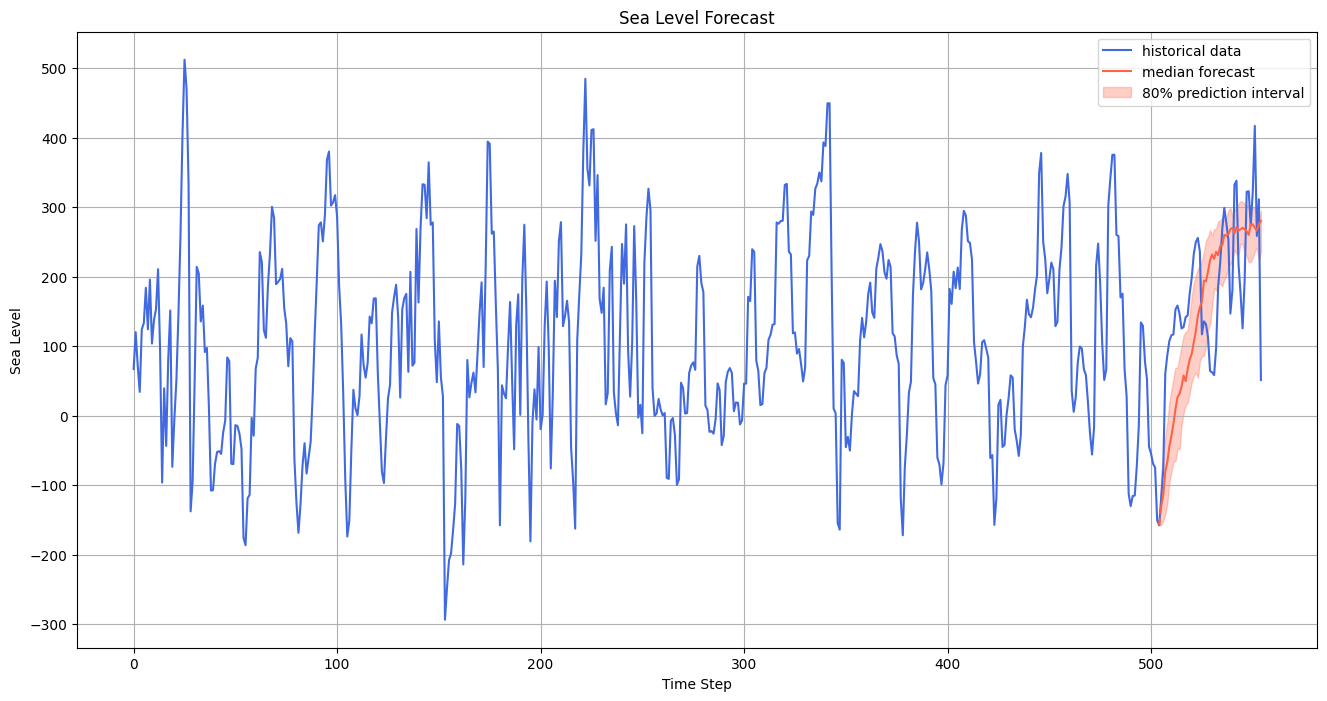

In [20]:
plot_forecast(sea_df['sea_level_altitude'][1100:], pipeline=pipeline_ft, n_forecast=50)

### Testing Chronos and the fine tuned method on the dataset from Copernicus

In [21]:
# Load the Copernicus dataset
df_test = pd.read_csv("/content/drive/MyDrive/dataset/Dataset_sea_level_extension/DATASET_COPERNICUS/COPERNICUS_sea_level_indicators_climate_global_area_averaged_DATA.csv")
df_test = df_test.rename(columns={"Time (years)": "time", "Mean Sea Level (cm)": "sea_level_altitude"})
df_test = df_test[["time", "sea_level_altitude"]]
# sea_level_altitude in mm
df_test["sea_level_altitude"] = df_test["sea_level_altitude"].apply(lambda x: x*10)

In [22]:
# Load the CSV, skipping the first 6 rows (metadata/header info)
df = pd.read_csv("/content/drive/MyDrive/dataset/Dataset_sea_level_extension/DATASET_NATURE_ARTICLE/global_mean_sea_level/slr_sla_gbl_keep_all_66.csv", skiprows=6)

# Rename the first column to 'time' for clarity
df.rename(columns={df.columns[0]: "time"}, inplace=True)

# Compute the mean value per row (ignoring NaNs), excluding the first column
df["sea_level_altitude"] = df.iloc[:, 1:].mean(axis=1, skipna=True)

# Create the final DataFrame with only the required columns
final_global_mean_df = df[["time", "sea_level_altitude"]]

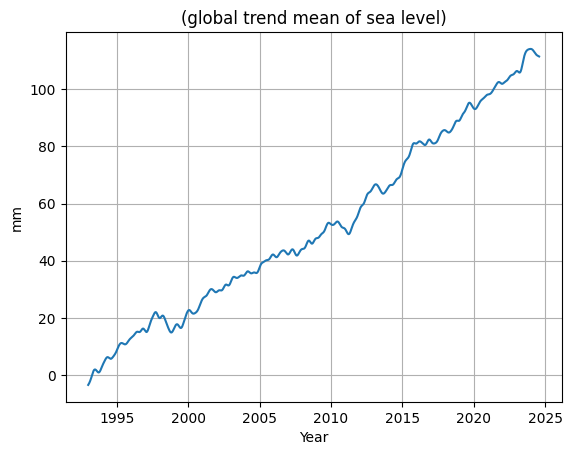

In [23]:
# Plotting
plt.ylabel("mm")
plt.xlabel("Year")
plt.grid()
plt.plot(df_test["time"], df_test["sea_level_altitude"])
plt.title("(global trend mean of sea level)")
plt.show()

In [24]:
print(f"\n🌊 Evaluating Chronos on Copernicus data")
entry = to_gluonts_entry(final_global_mean_df)
metrics = evaluate_sea_level_series(entry, pipeline, prediction_length=48)
mase = metrics["MASE[0.5]"].item()
wql = metrics["mean_weighted_sum_quantile_loss"].item()
mase, wql


🌊 Evaluating Chronos on Copernicus data


/tmp/ipython-input-13-2300273347.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["time"] = pd.to_datetime(df["time"])
0it [00:00, ?it/s]/usr/local/lib/python3.11/dist-packages/gluonts/time_feature/seasonality.py:47: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
1it [00:00, 159.73it/s]


(1.0288784547133902, 0.06283749665381147)

In [26]:
print(f"\n🌊 Evaluating Fine-tuned Chronos on Copernicus data")
entry = to_gluonts_entry(df_test)
metrics = evaluate_sea_level_series(entry, pipeline_ft, prediction_length=48)
mase = metrics["MASE[0.5]"].item()
wql = metrics["mean_weighted_sum_quantile_loss"].item()
mase, wql


🌊 Evaluating Fine-tuned Chronos on Copernicus data


0it [00:00, ?it/s]/usr/local/lib/python3.11/dist-packages/gluonts/time_feature/seasonality.py:47: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
1it [00:00, 83.82it/s]


(132.5316653079278, 0.2164507155468752)

In [27]:
print(f"\n🌊 Evaluating AutoARIMA on Copernicus data")
metrics = evaluate_with_autoarima(df_test, continuous_year=False)
mase = metrics["MASE[0.5]"].item()
wql = metrics["mean_weighted_sum_quantile_loss"].item()
mase, wql


🌊 Evaluating AutoARIMA on Copernicus data


1it [00:00, 85.66it/s]


(1.1686930262041058, 0.00014699662814037623)

### Comparison of Chronos, AutoARIMA and fine-tuned Chronos methods

In [28]:
def compare_mase_wql(
    df1: pd.DataFrame,
    df2: pd.DataFrame,
    delta: float = 0.05,
    name_model_1: str = "model 1",
    name_model_2: str = "model 2"
):
    """
    Compare MASE and WQL between two DataFrames for each sea,
    considering an improvement only if the difference is at least `delta`.

    Args:
        df1, df2: DataFrames with columns ['sea', 'MASE', 'WQL']
        delta: threshold to consider the improvement significant
        name_model_1: name of the first model (for display)
        name_model_2: name of the second model (for display)
    """
    merged = df1.merge(df2, on='sea', suffixes=('_1', '_2'))

    mase_better_1 = mase_better_2 = 0
    wql_better_1 = wql_better_2 = 0

    for _, row in merged.iterrows():
        # MASE: lower is better
        if row["MASE_1"] + delta < row["MASE_2"]:
            mase_better_1 += 1
        elif row["MASE_2"] + delta < row["MASE_1"]:
            mase_better_2 += 1

        # WQL: lower is better
        if row["WQL_1"] + delta < row["WQL_2"]:
            wql_better_1 += 1
        elif row["WQL_2"] + delta < row["WQL_1"]:
            wql_better_2 += 1

    print(f"📉 MASE: {name_model_1} is significantly better in {mase_better_1} seas, "
          f"{name_model_2} in {mase_better_2}")
    print(f"📉 WQL: {name_model_1} is significantly better in {wql_better_1} seas, "
          f"{name_model_2} in {wql_better_2}")

In [29]:
compare_mase_wql(final_chronos_finetuned_df, final_chronos_df, name_model_1 = "fine tuned Chronos", name_model_2 = "Chronos")

📉 MASE: fine tuned Chronos is significantly better in 10 seas, Chronos in 8
📉 WQL: fine tuned Chronos is significantly better in 9 seas, Chronos in 4


In [30]:
compare_mase_wql(final_chronos_finetuned_df, final_autoarima_df, name_model_1 = "fine tuned Chronos", name_model_2 = "AutoARIMA")

📉 MASE: fine tuned Chronos is significantly better in 21 seas, AutoARIMA in 0
📉 WQL: fine tuned Chronos is significantly better in 14 seas, AutoARIMA in 0


In [31]:
compare_mase_wql(final_chronos_df, final_autoarima_df, name_model_1 = "Chronos", name_model_2 = "AutoARIMA")

📉 MASE: Chronos is significantly better in 20 seas, AutoARIMA in 1
📉 WQL: Chronos is significantly better in 9 seas, AutoARIMA in 5
